In [1]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

## Load and Windowing Image

In [2]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [3]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [4]:
def load_and_plot_image(file_path, save=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    print(image.shape)
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)
    bone_image = window_image(hu_image, 400, 1000)
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')

    plt.subplot(151)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(hu_image)
    plt.title('Hu image')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(brain_image)
    plt.title('brain image')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(bone_image)
    plt.title('bone image')
    plt.axis('off')
    
    if save:
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-original.png'), image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-hu_image.png'), hu_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-brain_image.png'), brain_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-bone_image.png'), bone_image)

(512, 512)


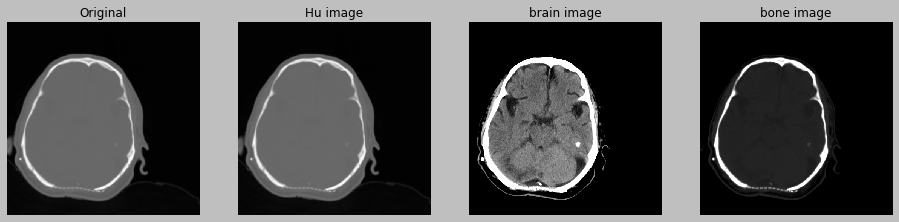

In [65]:
load_and_plot_image("ct_images/ct_example1.dcm")

(512, 512)


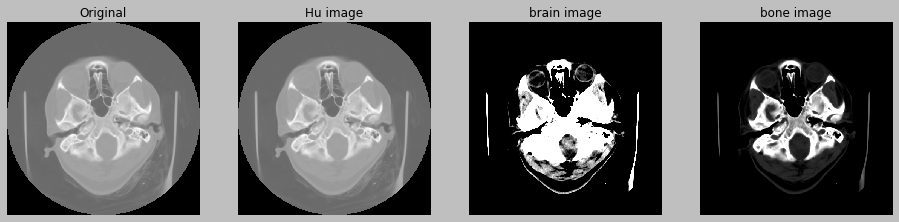

In [66]:
load_and_plot_image("ct_images/ct_example3.dcm")

(512, 512)


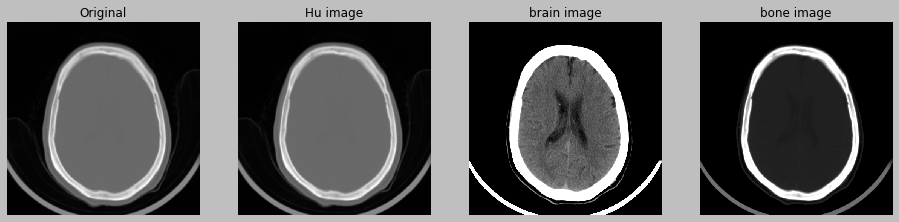

In [67]:
load_and_plot_image("ct_images/ct_example5.dcm")

(512, 512)


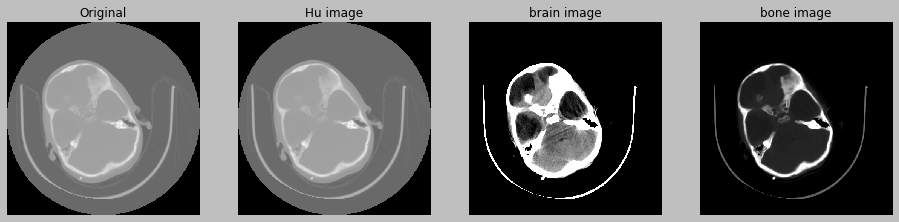

In [68]:
load_and_plot_image("ct_images/ct_example6.dcm")

## Improving Images

In [69]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

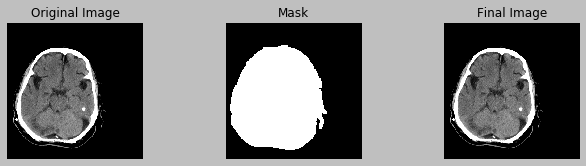

In [70]:
_ = remove_noise("ct_images/ct_example1.dcm", display=True)

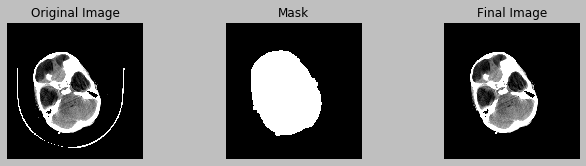

In [55]:
_ = remove_noise("ct_images/ct_example6.dcm", display=True)

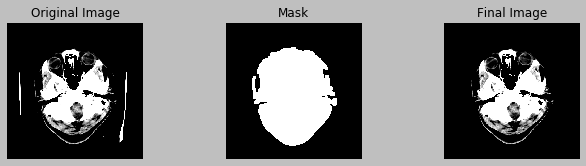

In [56]:
_ = remove_noise("ct_images/ct_example3.dcm", display=True)

In [52]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [57]:
final_image = remove_noise("ct_images/ct_example1.dcm")

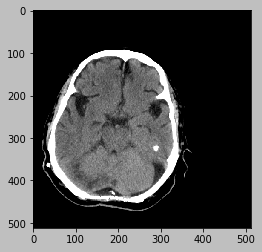

In [58]:
plt.imshow(final_image)

In [59]:
final_image = crop_image(final_image)

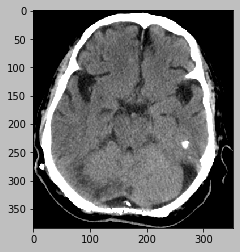

In [60]:
plt.imshow(final_image)

In [61]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [62]:
final_image = add_pad(final_image)

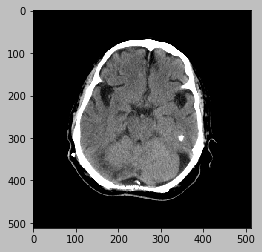

In [63]:
plt.imshow(final_image)

## Resampling

In [11]:
first_medical_image = pydicom.read_file("ct_images/ct_thickness_example21.dcm")
second_medical_image = pydicom.read_file("ct_images/ct_thickness_example22.dcm")

In [20]:
# we use the last axis
image_thickness = np.abs(first_medical_image.ImagePositionPatient[2] - second_medical_image.ImagePositionPatient[2])

In [16]:
image_thickness

0.6430000000000007

In [18]:
pixel_spacing = first_medical_image.PixelSpacing

In [19]:
pixel_spacing

['0.501953', '0.501953']

In [86]:
def resample(image, image_thickness, pixel_spacing):
    new_size = [1, 1, 1]
    
    x_pixel = float(pixel_spacing[0])
    y_pixel = float(pixel_spacing[1])
    
    size = np.array([x_pixel, y_pixel, float(image_thickness)])
    
    image_shape = np.array([image.shape[0], image.shape[1], 1])
    
    new_shape = image_shape * size
    new_shape = np.round(new_shape)
    resize_factor = new_shape / image_shape
    
    resampled_image = ndimage.interpolation.zoom(np.expand_dims(image, axis=2), resize_factor)
    
    return resampled_image

In [87]:
first_image = first_medical_image.pixel_array

In [88]:
first_image.shape

(512, 512)

In [89]:
resampled_image = resample(first_image, image_thickness, pixel_spacing)

In [94]:
np.squeeze(resampled_image).shape

(257, 257)